In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("Customer Segmentation").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/31 09:22:14 WARN Utils: Your hostname, shivams-MacBook-Air-2.local, resolves to a loopback address: 127.0.0.1; using 172.17.12.106 instead (on interface en0)
25/07/31 09:22:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/31 09:22:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark

In [5]:
df_pyspark = spark.read.option('header', 'true').csv('transactions_data.csv',inferSchema=True)
df_pyspark.show(3)

+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+------+
|     id|               date|client_id|card_id| amount|         use_chip|merchant_id|merchant_city|merchant_state|    zip| mcc|errors|
+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+------+
|7475327|2010-01-01 00:01:00|     1556|   2972|$-77.00|Swipe Transaction|      59935|       Beulah|            ND|58523.0|5499|  NULL|
|7475328|2010-01-01 00:02:00|      561|   4575| $14.57|Swipe Transaction|      67570|   Bettendorf|            IA|52722.0|5311|  NULL|
|7475329|2010-01-01 00:02:00|     1129|    102| $80.00|Swipe Transaction|      27092|        Vista|            CA|92084.0|4829|  NULL|
+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+------+
only showing top 3 rows


In [6]:
num_rows = df_pyspark.count()
num_cols = len(df_pyspark.columns)
shape = (num_rows, num_cols)
print("Shape:", shape)

Shape: (13305915, 12)


In [7]:
df_pyspark.head(3)

[Row(id=7475327, date=datetime.datetime(2010, 1, 1, 0, 1), client_id=1556, card_id=2972, amount='$-77.00', use_chip='Swipe Transaction', merchant_id=59935, merchant_city='Beulah', merchant_state='ND', zip=58523.0, mcc=5499, errors=None),
 Row(id=7475328, date=datetime.datetime(2010, 1, 1, 0, 2), client_id=561, card_id=4575, amount='$14.57', use_chip='Swipe Transaction', merchant_id=67570, merchant_city='Bettendorf', merchant_state='IA', zip=52722.0, mcc=5311, errors=None),
 Row(id=7475329, date=datetime.datetime(2010, 1, 1, 0, 2), client_id=1129, card_id=102, amount='$80.00', use_chip='Swipe Transaction', merchant_id=27092, merchant_city='Vista', merchant_state='CA', zip=92084.0, mcc=4829, errors=None)]

In [8]:
df_pyspark.printSchema()

root
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: string (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- zip: double (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)



In [9]:
df_pyspark.describe().show()

25/07/31 09:22:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+-----------------+------------------+--------+-----------------+------------------+-------------+--------------+-----------------+-----------------+----------------+
|summary|                  id|        client_id|           card_id|  amount|         use_chip|       merchant_id|merchant_city|merchant_state|              zip|              mcc|          errors|
+-------+--------------------+-----------------+------------------+--------+-----------------+------------------+-------------+--------------+-----------------+-----------------+----------------+
|  count|            13305915|         13305915|          13305915|13305915|         13305915|          13305915|     13305915|      11742215|         11653209|         13305915|          211393|
|   mean|1.5584024565583952E7|1026.812045845776| 3475.267650589982|    NULL|             NULL|47723.763181337024|         NULL|          NULL|51327.81983117268|5565.439814924415|            NULL|
| stddev|   4704498.

In [10]:
df_pyspark.na.drop() .show()

+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+--------------------+
|     id|               date|client_id|card_id| amount|         use_chip|merchant_id|merchant_city|merchant_state|    zip| mcc|              errors|
+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+--------------------+
|7475516|2010-01-01 04:56:00|      464|   3233|$104.10|Swipe Transaction|      32175|      Orlando|            FL|32804.0|7538|    Technical Glitch|
|7475792|2010-01-01 07:02:00|     1424|   4710|$-72.00|Swipe Transaction|      59935|      Kingman|            AZ|86401.0|5499|Insufficient Balance|
|7475881|2010-01-01 07:22:00|      843|    184| $37.54|Swipe Transaction|      89462|  Terre Haute|            IN|47805.0|5300|Insufficient Balance|
|7475882|2010-01-01 07:22:00|     1424|   4710| $72.00|Swipe Transaction|      59935|      Kingman|       

In [11]:
num_rows = df_pyspark.count()
num_cols = len(df_pyspark.columns)
shape = (num_rows, num_cols)
print("Shape:", shape)


Shape: (13305915, 12)


In [12]:
import json

with open('mcc_codes.json', 'r') as f:
    mcc_map = json.load(f)

from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

def mcc_to_category(mcc):
    return mcc_map.get(str(mcc), 'Other')

mcc_to_category_udf = udf(mcc_to_category, StringType())

df_pyspark = df_pyspark.withColumn('category', mcc_to_category_udf(col('mcc')))


In [13]:
from pyspark.sql.functions import regexp_replace, trim

df_pyspark = df_pyspark.withColumn(
    "amount",
    regexp_replace(trim(col("amount")), "[$,]", "").cast("float")
)
df_pyspark.show(3)

+-------+-------------------+---------+-------+------+-----------------+-----------+-------------+--------------+-------+----+------+--------------------+
|     id|               date|client_id|card_id|amount|         use_chip|merchant_id|merchant_city|merchant_state|    zip| mcc|errors|            category|
+-------+-------------------+---------+-------+------+-----------------+-----------+-------------+--------------+-------+----+------+--------------------+
|7475327|2010-01-01 00:01:00|     1556|   2972| -77.0|Swipe Transaction|      59935|       Beulah|            ND|58523.0|5499|  NULL|Miscellaneous Foo...|
|7475328|2010-01-01 00:02:00|      561|   4575| 14.57|Swipe Transaction|      67570|   Bettendorf|            IA|52722.0|5311|  NULL|   Department Stores|
|7475329|2010-01-01 00:02:00|     1129|    102|  80.0|Swipe Transaction|      27092|        Vista|            CA|92084.0|4829|  NULL|      Money Transfer|
+-------+-------------------+---------+-------+------+----------------

In [14]:
df_pyspark.printSchema()

root
 |-- id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_id: integer (nullable = true)
 |-- amount: float (nullable = true)
 |-- use_chip: string (nullable = true)
 |-- merchant_id: integer (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- zip: double (nullable = true)
 |-- mcc: integer (nullable = true)
 |-- errors: string (nullable = true)
 |-- category: string (nullable = true)



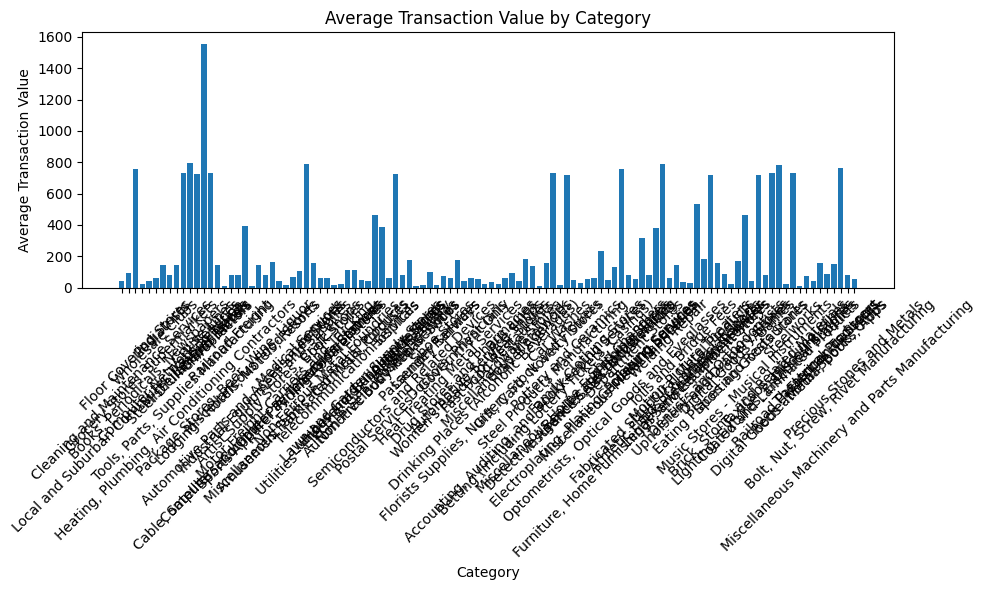

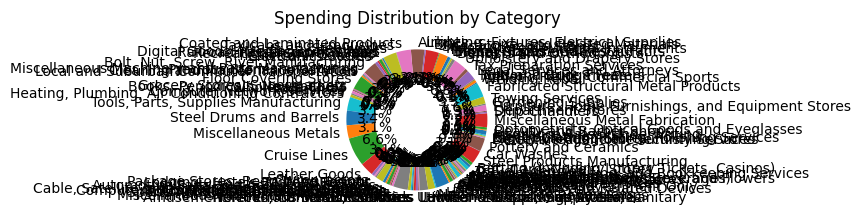

In [15]:
avg_by_category = df_pyspark.groupBy('category').avg('amount')
avg_by_category = avg_by_category.withColumnRenamed('avg(amount)', 'average_amount')
avg_by_category_pd = avg_by_category.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(avg_by_category_pd['category'], avg_by_category_pd['average_amount'])
plt.xlabel('Category')
plt.ylabel('Average Transaction Value')
plt.title('Average Transaction Value by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,8))
plt.pie(
    avg_by_category_pd['average_amount'],
    labels=avg_by_category_pd['category'],
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops=dict(width=0.4)
)
plt.title('Spending Distribution by Category')
plt.tight_layout()
plt.show()  

In [16]:
from pyspark.sql import functions as F

summary = (
    df_pyspark.groupBy('category')
    .agg(
        F.count('*').alias('transaction_count'),
        F.sum('amount').alias('total_amount'),
        F.avg('amount').alias('average_amount')
    )
    .orderBy(F.desc('total_amount'))
)
summary.show()

+--------------------+-----------------+--------------------+------------------+
|            category|transaction_count|        total_amount|    average_amount|
+--------------------+-----------------+--------------------+------------------+
|      Money Transfer|           589140|5.3158515640115425E7| 90.23070176887569|
|Grocery Stores, S...|          1592584| 4.097075415143882E7|25.725961174693968|
|     Wholesale Clubs|           601942| 3.769754673757358E7| 62.62654331741859|
|Drug Stores and P...|           772913|3.5113527688910685E7| 45.43011657057222|
|    Service Stations|          1424711|2.9570426659486763E7|20.755385941069285|
|Utilities - Elect...|           242993|2.7650038079564877E7|113.78944282166513|
|   Department Stores|           475384|2.7031968701245077E7| 56.86343819153585|
|Eating Places and...|           999738| 2.634822546778105E7|26.355130511975187|
|Automotive Servic...|           478263| 2.495564072930509E7|52.179743633325366|
|Telecommunication...|      

In [17]:
summary_pd = summary.toPandas()
summary_pd.to_csv('category_summary.csv', index=False)
print("Exported summary to category_summary.csv")

Exported summary to category_summary.csv


In [18]:
from pyspark.sql.functions import month, year

monthly_summary = (
    df_pyspark
    .withColumn('month', month('date'))
    .withColumn('year', year('date'))
    .groupBy('year', 'month')
    .agg(
        F.count('*').alias('transaction_count'),
        F.sum('amount').alias('total_amount')
    )
    .orderBy('year', 'month')
)
monthly_summary.show()
monthly_summary_pd = monthly_summary.toPandas()
monthly_summary_pd.to_csv('monthly_summary.csv', index=False)
print("Exported monthly summary to monthly_summary.csv")

+----+-----+-----------------+------------------+
|year|month|transaction_count|      total_amount|
+----+-----+-----------------+------------------+
|2010|    1|           101209| 4372532.120714137|
|2010|    2|            93470|4103170.2388747223|
|2010|    3|           103345| 4539853.380160635|
|2010|    4|           100169| 4407951.329488356|
|2010|    5|           104773| 4610601.800002312|
|2010|    6|           102677| 4509874.370245637|
|2010|    7|           106034| 4660340.550494812|
|2010|    8|           107547|  4688090.24037453|
|2010|    9|           103902| 4540028.900412314|
|2010|   10|           106150| 4623129.080634976|
|2010|   11|           103721| 4491306.770645842|
|2010|   12|           107883| 4685677.339407064|
|2011|    1|           107821| 4648395.040004745|
|2011|    2|            97395| 4174994.470140109|
|2011|    3|           108235| 4718656.139681809|
|2011|    4|           105662| 4603020.729547789|
|2011|    5|           108946| 4642923.290503779|


Exported monthly summary to monthly_summary.csv


In [19]:
state_summary = (
    df_pyspark.groupBy('merchant_state')
    .agg(
        F.count('*').alias('transaction_count'),
        F.sum('amount').alias('total_amount'),
        F.avg('amount').alias('average_amount')
    )
    .orderBy(F.desc('total_amount'))
)
state_summary.show()
state_summary_pd = state_summary.toPandas()
state_summary_pd.to_csv('state_summary.csv', index=False)
print("Exported state summary to state_summary.csv")

+--------------+-----------------+--------------------+------------------+
|merchant_state|transaction_count|        total_amount|    average_amount|
+--------------+-----------------+--------------------+------------------+
|          NULL|          1563700| 8.889666508761346E7| 56.85020469886389|
|            CA|          1427087| 5.908461618892796E7| 41.40225241273164|
|            TX|          1010207| 4.247720842920158E7| 42.04802424572546|
|            NY|           857510| 3.972164777021158E7|  46.3220811071726|
|            FL|           701623|2.8603402231543522E7|  40.7674808715557|
|            IL|           467931|1.9500277778161597E7| 41.67340436551884|
|            PA|           417766| 1.823498855935467E7| 43.64880952340466|
|            NC|           429427|1.6790704150507346E7| 39.10025254701578|
|            OH|           484122|1.6225273040668325E7| 33.51484344993271|
|            MI|           397970| 1.505146402961923E7| 37.82059961710488|
|            NJ|         

Exported state summary to state_summary.csv


In [20]:
merchant_summary = (
    df_pyspark.groupBy('merchant_id')
    .agg(
        F.count('*').alias('transaction_count'),
        F.sum('amount').alias('total_amount')
    )
    .orderBy(F.desc('total_amount'))
    .limit(10)
)
merchant_summary.show()
merchant_summary_pd = merchant_summary.toPandas()
merchant_summary_pd.to_csv('merchant_summary.csv', index=False)
print("Exported merchant summary to merchant_summary.csv")

+-----------+-----------------+--------------------+
|merchant_id|transaction_count|        total_amount|
+-----------+-----------------+--------------------+
|      27092|           589140|5.3158515640115425E7|
|      60569|           301657|1.8900001407501925E7|
|      39021|           440281| 1.572539627014795E7|
|      61195|           562410|1.2013083648693418E7|
|      73186|           105351| 1.166481306845782E7|
|      20561|           202639|   8995659.099213347|
|      59935|           610053|   8937586.068794386|
|      50783|           298231|    7717215.21057282|
|      22204|           347511|   7385156.100053592|
|      75781|           273351|   6692820.159934787|
+-----------+-----------------+--------------------+



Exported merchant summary to merchant_summary.csv


In [21]:
error_summary = (
    df_pyspark.groupBy('errors')
    .agg(F.count('*').alias('transaction_count'))
    .orderBy(F.desc('transaction_count'))
)
error_summary.show()
error_summary_pd = error_summary.toPandas()
error_summary_pd.to_csv('error_summary.csv', index=False)
print("Exported error summary to error_summary.csv")

+--------------------+-----------------+
|              errors|transaction_count|
+--------------------+-----------------+
|                NULL|         13094522|
|Insufficient Balance|           130902|
|             Bad PIN|            32119|
|    Technical Glitch|            26271|
|     Bad Card Number|             7767|
|      Bad Expiration|             6161|
|             Bad CVV|             6106|
|         Bad Zipcode|             1126|
|Bad PIN,Insuffici...|              293|
|Insufficient Bala...|              243|
|Bad Card Number,I...|               71|
|Bad PIN,Technical...|               70|
|Bad CVV,Insuffici...|               57|
|Bad Expiration,In...|               47|
|Bad Card Number,B...|               38|
|Bad Card Number,B...|               33|
|Bad Expiration,Ba...|               32|
|Bad Expiration,Te...|               21|
|Bad Card Number,T...|               15|
|Bad CVV,Technical...|                8|
+--------------------+-----------------+
only showing top

Exported error summary to error_summary.csv


In [ ]:
! pip install nbformat

In [23]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "notebook_connected"

fig = px.bar(
    summary_pd,
    x='category',
    y='total_amount',
    color='average_amount',
    title='Total Spend by Category (Colored by Average Transaction Value)',
    text='transaction_count'
)
fig.update_layout(xaxis_title='Category', yaxis_title='Total Spend', template='plotly_white')

try:
    fig.show()
except Exception as e:

    fig.write_html("category_summary_plot.html")
    print("Plot could not be displayed in the notebook. Saved as 'category_summary_plot.html'. Open this file in your browser to view the chart.")

In [24]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

fig = px.bar(
    summary_pd,
    x='category',
    y='total_amount',
    color='average_amount',
    title='Total Spend by Category (Colored by Average Transaction Value)',
    text='transaction_count'
)
fig.update_layout(xaxis_title='Category', yaxis_title='Total Spend', template='plotly_white')

try:
    fig.show()
except Exception as e:
    fig.write_html("category_summary_plot.html")
    print("Plot could not be displayed in the notebook. Saved as 'category_summary_plot.html'. Open this file in your browser to view the chart.")

In [25]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "notebook_connected"

top_states = state_summary_pd.sort_values("total_amount", ascending=False).head(20)
fig = px.bar(
    top_states,
    x='merchant_state',
    y='total_amount',
    color='average_amount',
    title='Top 20 States by Total Spend',
    text='transaction_count'
)
fig.update_layout(xaxis_title='State', yaxis_title='Total Spend', template='plotly_white')
try:
    fig.show()
except Exception:
    fig.write_html("state_summary_plot.html")
    print("Plot saved as 'state_summary_plot.html'. Open in browser.")

In [27]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "notebook_connected"


top_errors = error_summary_pd.sort_values("transaction_count", ascending=False).head(10)
fig = px.bar(
    top_errors,
    x='errors',
    y='transaction_count',
    title='Top 10 Transaction Error Types',
    text='transaction_count'
)
fig.update_layout(xaxis_title='Error Type', yaxis_title='Transaction Count', template='plotly_white')
try:
    fig.show()
except Exception:
    fig.write_html("error_summary_plot.html")
    print("Plot saved as 'error_summary_plot.html'. Open in browser.")